In [7]:
%matplotlib inline
%load_ext memory_profiler
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib as mpl
from yellowbrick.style import rcmod
from scipy.stats import spearmanr
from memory_profiler import profile

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [8]:
# Yellowbrick changes the plotting settings, reset to default here
rcmod.reset_orig()

# Problem 1

1. Load the data

In [10]:
X = np.load("/Users/zainabbajaj/Downloads/data 2/p1/X.npy")
y = np.load("/Users/zainabbajaj/Downloads/data 2/p1/y.npy")

In [11]:
# 511 cells, 45768 genes
print(X.shape)

(511, 45768)


In [12]:
# Largest entry of first column
np.max(X[:,0])

np.float64(11.941397591320595)

2. Log transform

In [13]:
# Log 
X_log = np.log2(X + 1)

In [14]:
# Largest entry of first column
print(np.max(X_log[:,0]))

3.6939215228197613


3. Full PCA, raw vs transformed data

In [15]:
%%timeit -n 1 -r 1
%%memit -r 1
pca = PCA().fit(X)
pca_log = PCA().fit(X_log)

peak memory: 853.83 MiB, increment: 672.73 MiB
25.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
# Percentage of variance explained by first component
print("First component raw:", pca.explained_variance_ratio_[0])
print("First component log:", pca_log.explained_variance_ratio_[0])

First component raw: 0.42779670983572615
First component log: 0.1388756487082618


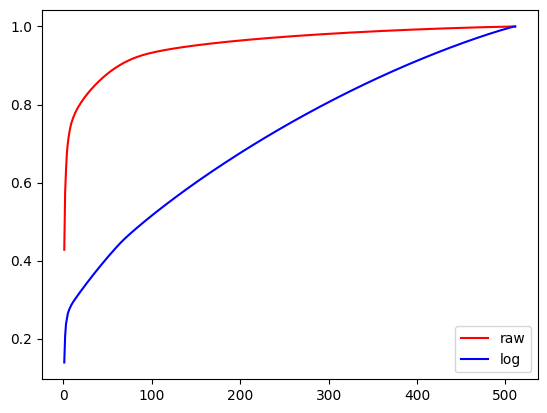

In [17]:
# Cumulative variance explained plots
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), color="red", label="raw")
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), color="blue", label="log")
plt.legend()
plt.show()

In [18]:
# 85% variance cutoffs
print("Raw:", np.where(np.cumsum(pca.explained_variance_ratio_) >= .85)[0][0] + 1)
print("Log:", np.where(np.cumsum(pca_log.explained_variance_ratio_) >= .85)[0][0] + 1)

Raw: 36
Log: 339


Remember that we want to find genes that can differentiate between cells, even if the genes are not expressed in many cells and/or have low levels of expression. For example, if a particular gene has $0$ expression for $80$ cells and $0.2$ expression for $20$ cells, that would contribute much less to the variance than a gene with $0$ expression for $50$ cells and $0.8$ expression for $50$ cells. While the latter gene might just differentiate between neuron vs non-neuron (for example),  the former gene might differentiate between specific cell types.  But the variances differ greatly and we don't want to make the conclusion that the latter gene is sufficient for explaining the variation between cells in the data.

4. Plotting without visualization techniques

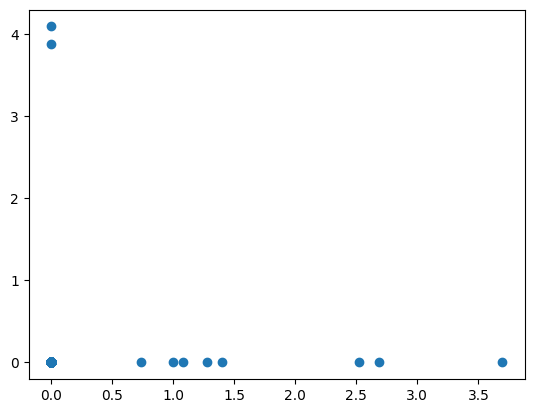

In [19]:
# Nothing informative!
plt.scatter(X_log[:,0],X_log[:,1])

5. PCA visualization

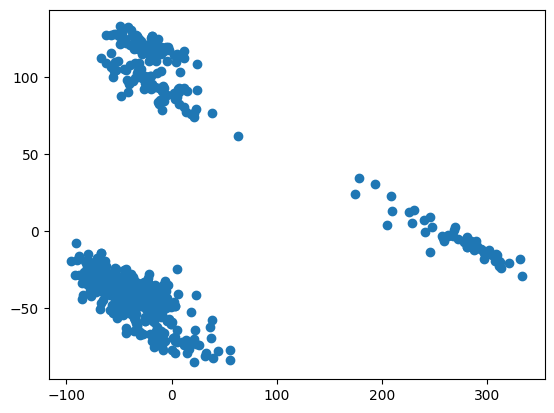

In [20]:
# Three visually distinct clusters. Could potentially argue for 4 or 5 as well, but these are not well-separated
z = pca_log.transform(X_log)
plt.scatter(z[:,0],z[:,1])

6. MDS (sklearn version is nonlinear)

2127446079.3262384


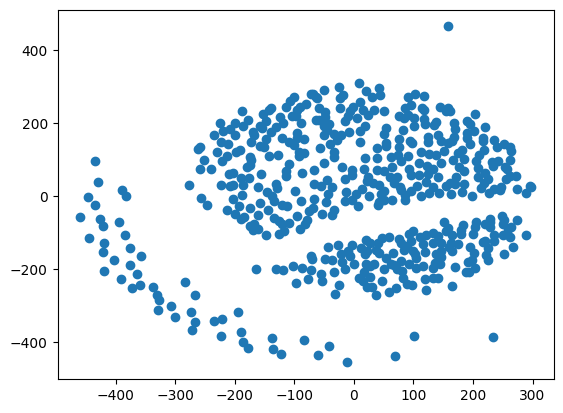

In [22]:
# Since there is randomization in the initial state, run this multiple times and use the result with the best objective function value.  (Also be aware that some initializations can give you suboptimal local minima for both MDS and T-SNE algorithms). 
#We still see 3 distinct clusters.  
mds_class=MDS(n_components=2)
mds=mds_class.fit_transform(X_log)
print(mds_class.stress_)
plt.scatter(mds[:,0],mds[:,1])

7. T-SNE

0.3486272692680359


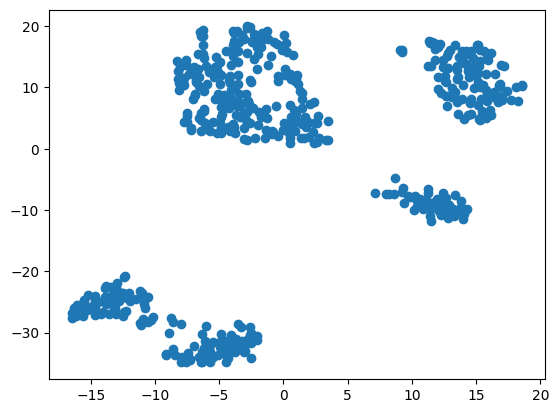

In [73]:
# Emergence of at least 5 clusters. 
# Since there is randomization in the initial state, run this multiple times and use the result with the best objective function value.  (Also be aware that some initializations can give you suboptimal local minima for both MDS and T-SNE algorithms).

z_tsne_class = TSNE(n_components=2,perplexity=40)
z_tsne=z_tsne_class.fit_transform(z[:,0:50])
print(z_tsne_class.kl_divergence_)
plt.scatter(z_tsne[:,0],z_tsne[:,1])


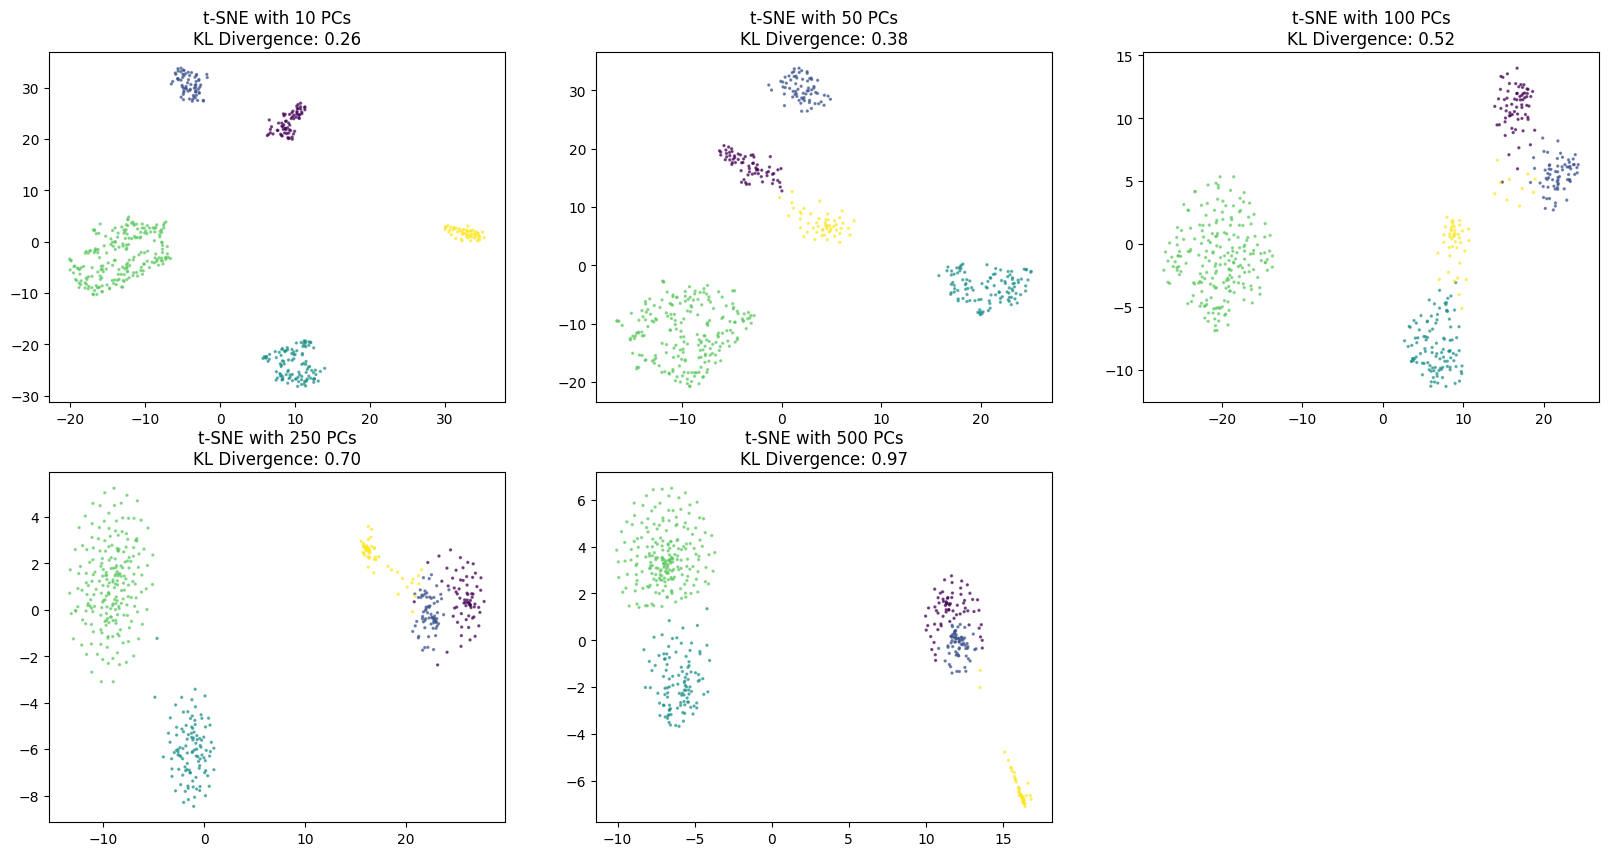

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Load the data
X = np.load("/Users/zainabbajaj/Downloads/data 2/p1/X.npy")
y = np.load("/Users/zainabbajaj/Downloads/data 2/p1/y.npy")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Log transform
X_log = np.log2(X + 1)

# PCA on log-transformed data
pca_log = PCA().fit(X_log)

# Transform the log-transformed data
z = pca_log.transform(X_log)

# Function to run t-SNE on different numbers of PCs
def run_tsne(data, n_pcs):
    pca = PCA(n_components=n_pcs)
    data_pca = pca.fit_transform(data)
    tsne = TSNE(n_components=2, perplexity=40, random_state=42)
    data_tsne = tsne.fit_transform(data_pca)
    return data_tsne, tsne.kl_divergence_

# Number of PCs to use
pcs = [10, 50, 100, 250, 500]

# Plotting
plt.figure(figsize=(20, 10))
for i, n_pcs in enumerate(pcs):
    data_tsne, kl_divergence = run_tsne(X_log, n_pcs)
    plt.subplot(2, 3, i+1)
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], s=2, alpha=0.6, c=y)
    plt.title(f't-SNE with {n_pcs} PCs\nKL Divergence: {kl_divergence:.2f}')
plt.show()


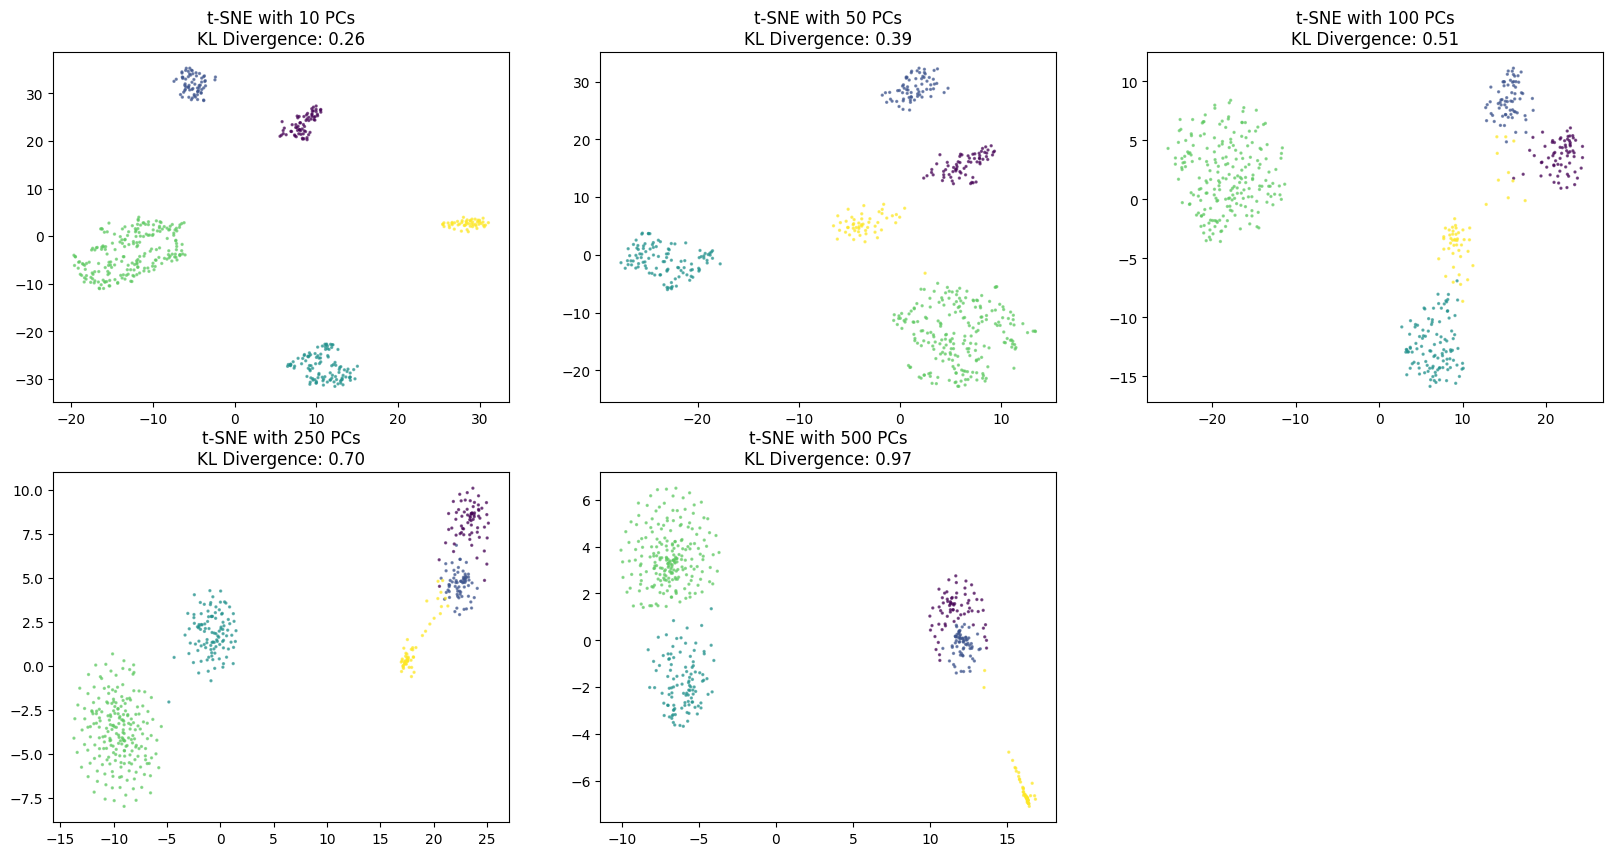

Variance explained by first component (raw data): 0.43
Variance explained by first component (log-transformed data): 0.14
85% variance cutoff (raw data): 36 PCs
85% variance cutoff (log-transformed data): 339 PCs
KL Divergence values for t-SNE with different PCs: [0.2554693818092346, 0.39008647203445435, 0.5118639469146729, 0.6961728930473328, 0.9658750295639038]


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Load the data
X = np.load("/Users/zainabbajaj/Downloads/data 2/p1/X.npy")
y = np.load("/Users/zainabbajaj/Downloads/data 2/p1/y.npy")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Log transform
X_log = np.log2(X + 1)

# Full PCA on raw and log-transformed data
pca_raw = PCA().fit(X)
pca_log = PCA().fit(X_log)

# Variance explained by first component
first_comp_raw = pca_raw.explained_variance_ratio_[0]
first_comp_log = pca_log.explained_variance_ratio_[0]

# 85% variance cutoffs
var_85_raw = np.where(np.cumsum(pca_raw.explained_variance_ratio_) >= 0.85)[0][0] + 1
var_85_log = np.where(np.cumsum(pca_log.explained_variance_ratio_) >= 0.85)[0][0] + 1

# Function to run t-SNE on different numbers of PCs
def run_tsne(data, n_pcs):
    pca = PCA(n_components=n_pcs)
    data_pca = pca.fit_transform(data)
    tsne = TSNE(n_components=2, perplexity=40, random_state=42)
    data_tsne = tsne.fit_transform(data_pca)
    return data_tsne, tsne.kl_divergence_

# Number of PCs to use
pcs = [10, 50, 100, 250, 500]

# Store KL divergence values
kl_divergences = []

# Plotting
plt.figure(figsize=(20, 10))
for i, n_pcs in enumerate(pcs):
    data_tsne, kl_divergence = run_tsne(X_log, n_pcs)
    kl_divergences.append(kl_divergence)
    plt.subplot(2, 3, i+1)
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], s=2, alpha=0.6, c=y)
    plt.title(f't-SNE with {n_pcs} PCs\nKL Divergence: {kl_divergence:.2f}')
plt.show()

# Print the quantitative figures
print(f"Variance explained by first component (raw data): {first_comp_raw:.2f}")
print(f"Variance explained by first component (log-transformed data): {first_comp_log:.2f}")
print(f"85% variance cutoff (raw data): {var_85_raw} PCs")
print(f"85% variance cutoff (log-transformed data): {var_85_log} PCs")
print(f"KL Divergence values for t-SNE with different PCs: {kl_divergences}")


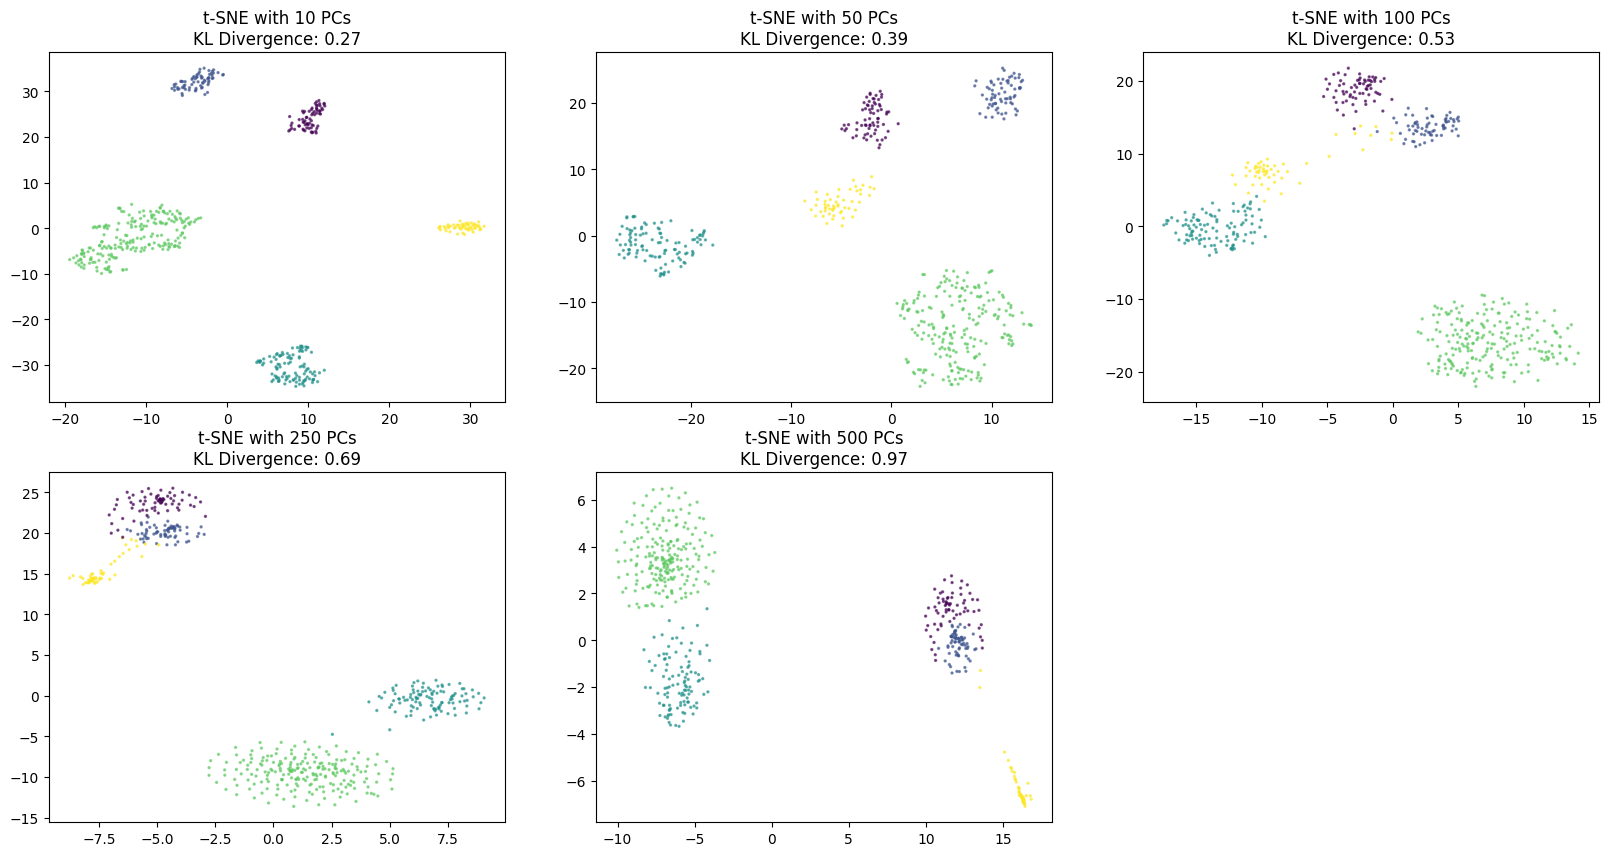

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Load the data
X = np.load("/Users/zainabbajaj/Downloads/data 2/p1/X.npy")
y = np.load("/Users/zainabbajaj/Downloads/data 2/p1/y.npy")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Log transform
X_log = np.log2(X + 1)

# PCA on log-transformed data
pca_log = PCA().fit(X_log)

# Transform the log-transformed data
z = pca_log.transform(X_log)

# Function to run t-SNE on different numbers of PCs
def run_tsne(data, n_pcs):
    pca = PCA(n_components=n_pcs)
    data_pca = pca.fit_transform(data)
    tsne = TSNE(n_components=2, perplexity=40, random_state=42)
    data_tsne = tsne.fit_transform(data_pca)
    return data_tsne, tsne.kl_divergence_

# Number of PCs to use
pcs = [10, 50, 100, 250, 500]

# Store KL divergence values
kl_divergences = []

# Plotting
plt.figure(figsize=(20, 10))
for i, n_pcs in enumerate(pcs):
    data_tsne, kl_divergence = run_tsne(X_log, n_pcs)
    kl_divergences.append(kl_divergence)
    plt.subplot(2, 3, i+1)
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], s=2, alpha=0.6, c=y)
    plt.title(f't-SNE with {n_pcs} PCs\nKL Divergence: {kl_divergence:.2f}')
plt.show()


8. K-Means: From the T-SNE plot (with the lowest KL-divergence), we can see the emergence of 5 clusters. 


In [27]:
# K-means with n=5, as decided from T-SNE plot above; 
# Run multiple times and explore settings to get the lowest inertia_, such aa:
# init='random', or random_state=0  
kmeans = KMeans(5, tol=1e-6) 
kmeans.fit(z[:,0:50])
print(kmeans.inertia_)

6115696.37155819


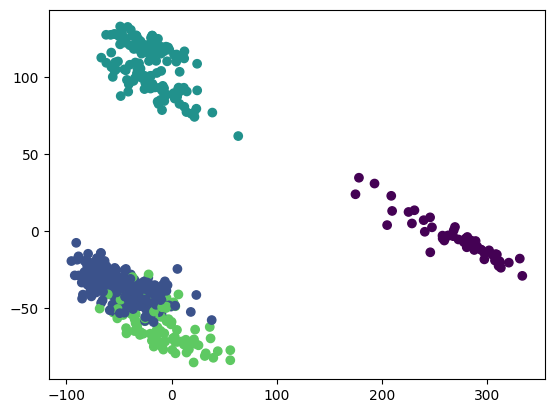

In [28]:
#PCA plot colored with K-means clusters
plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)

2128163349.7301662


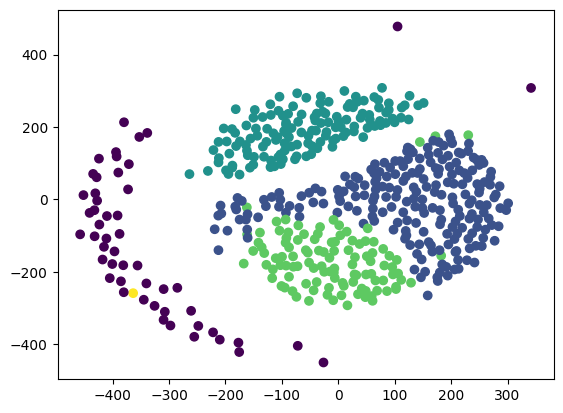

In [29]:
# MDS plot with 5 K-means clusters, on log-transformed data:
mds=mds_class.fit_transform(X_log)
print(mds_class.stress_)
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

264527357.77425507


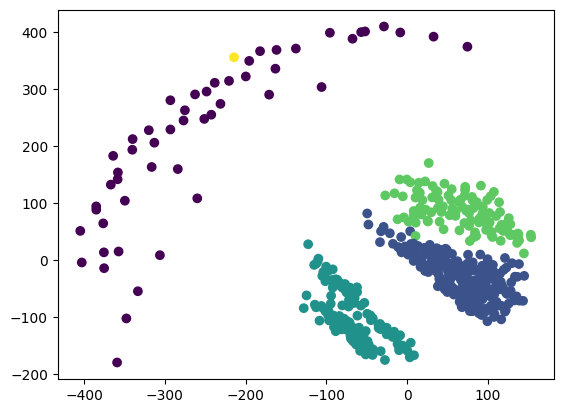

In [30]:
# Alternatively, MDS on first 50 PCS of log-transformed data
# colored with the 5 K-means clusters:
mds_class=MDS(n_components=2)
mds=mds_class.fit_transform(z[:,0:50])
print(mds_class.stress_)
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

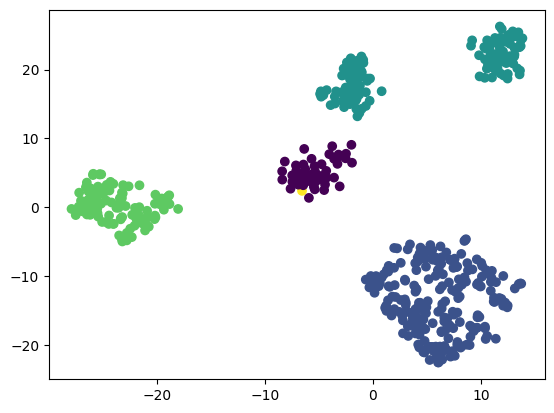

In [31]:
# T-SNE on first 50 PCS of log-transformed data,
# colored with 4 K-means clusters 

plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

9. Elbow method.

Num clusters 2 Inertia: 11572486.520376794
Num clusters 3 Inertia: 7257882.201193232
Num clusters 4 Inertia: 6202929.841899473
Num clusters 5 Inertia: 6034080.587763501
Num clusters 6 Inertia: 5820141.0765478825
Num clusters 7 Inertia: 5755391.465028812
Num clusters 8 Inertia: 5623298.943764889
Num clusters 9 Inertia: 5174852.325421248


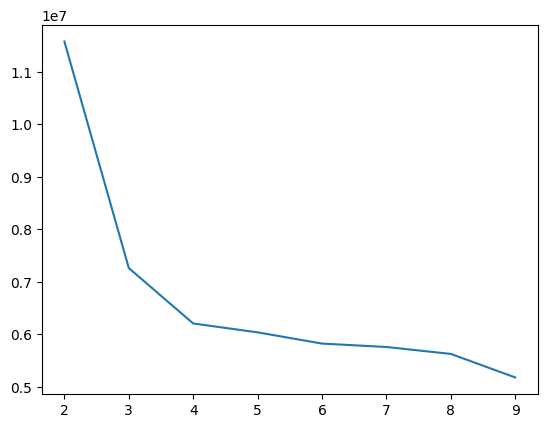

In [52]:
# Would select 3, 4, or 5 clusters
all_kmeans = [i for i in range(8)]
for i in range(8):
    cur_kmeans = KMeans(i+2)
    cur_kmeans.fit(z[:,0:50])
    print("Num clusters", i+2, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+2 for i in range(8)], [all_kmeans[i].inertia_ for i in range(8)])

10. Hierarchical clustering: Dendrogram in R script

11. MDS on cluster means. Confirms 3 groups, one with 1 cluster and two with 2 clusters each. Accurate representation of distances - one cluster is far away from others, indicating a different type of cell. But T-SNE consistently puts it in the middle of the plot.

In [53]:
# MDS on kmeans cluster means
cmeans = np.zeros((5,X_log.shape[1]))
for c in range(5):
    cmeans[c] = np.mean(X_log[np.where(kmeans.labels_==c)[0]],axis=0)

breaking at iteration 169 with stress 7886.538688904587
breaking at iteration 45 with stress 8093.032758070486
breaking at iteration 54 with stress 8093.033156550285
breaking at iteration 67 with stress 7886.53826895374


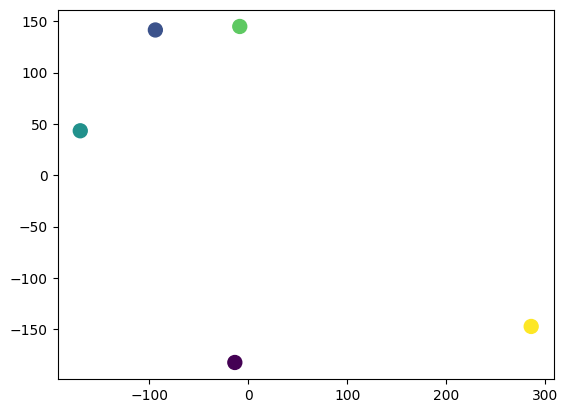

In [54]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(cmeans)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=[0,1,2,3,4],s=100)

In MDS, we see one group with 1 cluster mean and two groups with 2 cluster means each. MDS aim to respresent distances accurately.  The one cluster that far away from the other indicates a different type of cell.

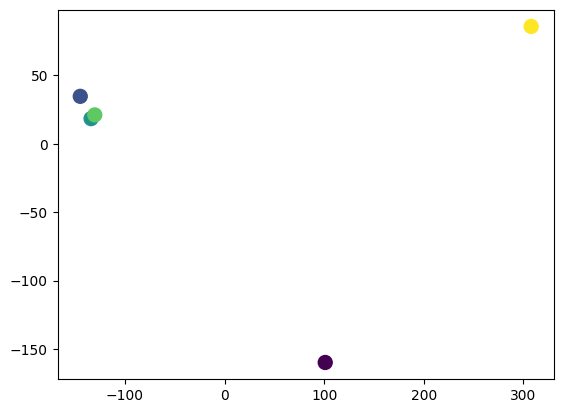

In [62]:
# PCA on cluster means
z_means = PCA(2).fit_transform(cmeans)
plt.scatter(z_means[:,0],z_means[:,1],c=[0,1,2,3,4],s=100)

Similarly, in PCA,  we again see one group with 1 cluster mean and two groups with 2 cluster means each. PCA is a linear projection, hence the distances in the PC directions are preserved.  The one cluster that far away from the other indicates a different type of cell.

In [56]:
# Emergence of at least 5 clusters. 
z_means_tsne = TSNE(n_components=2,perplexity=40).fit_transform(cmeans)
plt.scatter(z_means_tsne[:,0],z_means_tsne[:,1],c=[0,1,2,3,4],s=100)

ValueError: perplexity must be less than n_samples

T-SNE does not represent distances accurately.  The hierarchical structure of the 5 clusters falling into 3 groups are lost.   (on the other hand, we saw that the 5 clusters are well separated.)

12. PCA/T-SNE on Raw Data

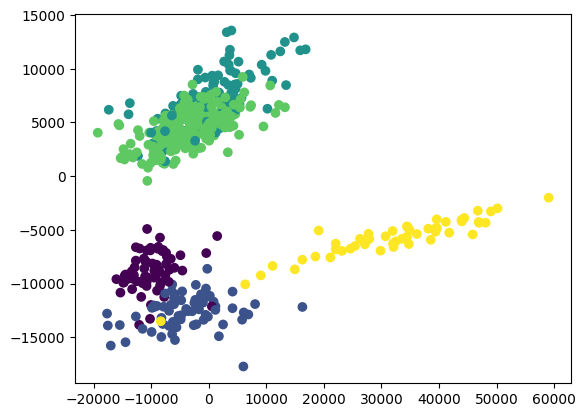

In [63]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1],c=y)

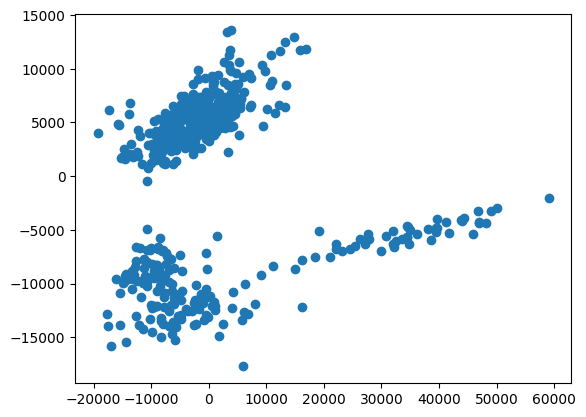

In [64]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1])

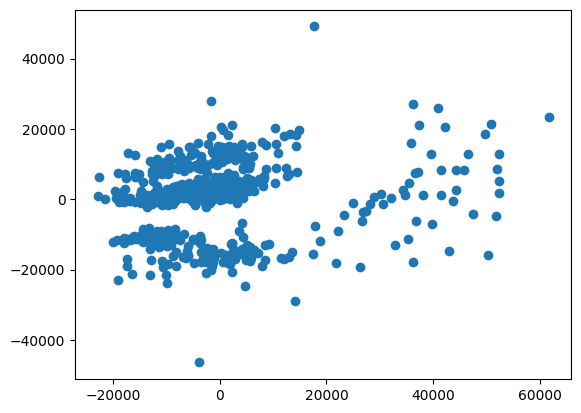

In [65]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(z[:,0:50])
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1])

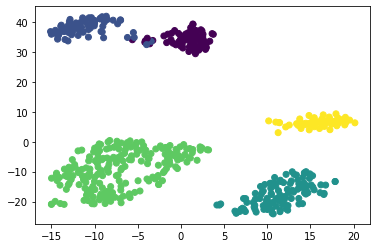

In [62]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)

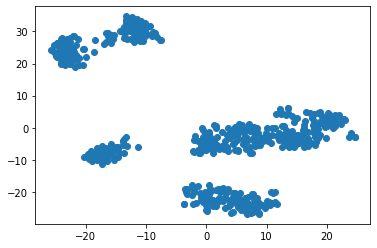

In [63]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])

The log transformed data produced more clearly defined clusters. This typically happens for this type of data.  